In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
!pip install wordcloud


In [ ]:
pip install iterative-stratification


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
path = "/content/gdrive/MyDrive/subtask_2swa/swa_train.csv"
df = pd.read_csv(path)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (6991, 7)


,id,text,political,racial/ethnic,religious,gender/sexual,other
0,swa_53de6a7a4d0123b5755da79d8d97a82f,uwizi rt kenyan rao akishinda nitachinja kuku ...,0,1,0,0,0
1,swa_ee2533cb334df97236ea2bcfda0d6823,wakikuyu ndio wako na manyumba za kukodeshwa t...,0,1,0,0,0
2,swa_1dd81b5985840a55b1ab292aa65d11a8,wakikuyu ni wezi power hungry and this time we...,0,1,0,0,0
3,swa_18589adc3945e20c5e5c61e10245fad1,wakikuyu sijui shida yenu ni nini kuogopa rail...,0,1,0,0,0
4,swa_aee76fc4cd1c6c6c09e19ba5ddd3901a,wakikuyu walisogwa hwakuumbwa,0,1,0,0,0


In [ ]:
LABEL_COLS = ["political", "racial/ethnic", "religious", "gender/sexual", "other"]
TEXT_COL = "text"

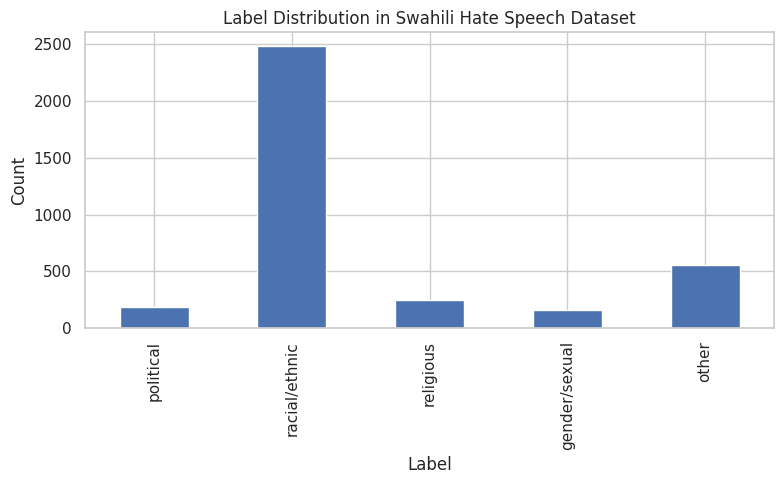

In [ ]:
# Count how many samples for each category
label_counts = df[LABEL_COLS].sum()

plt.figure(figsize=(8,5))
label_counts.plot(kind='bar')
plt.title("Label Distribution in Swahili Hate Speech Dataset")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


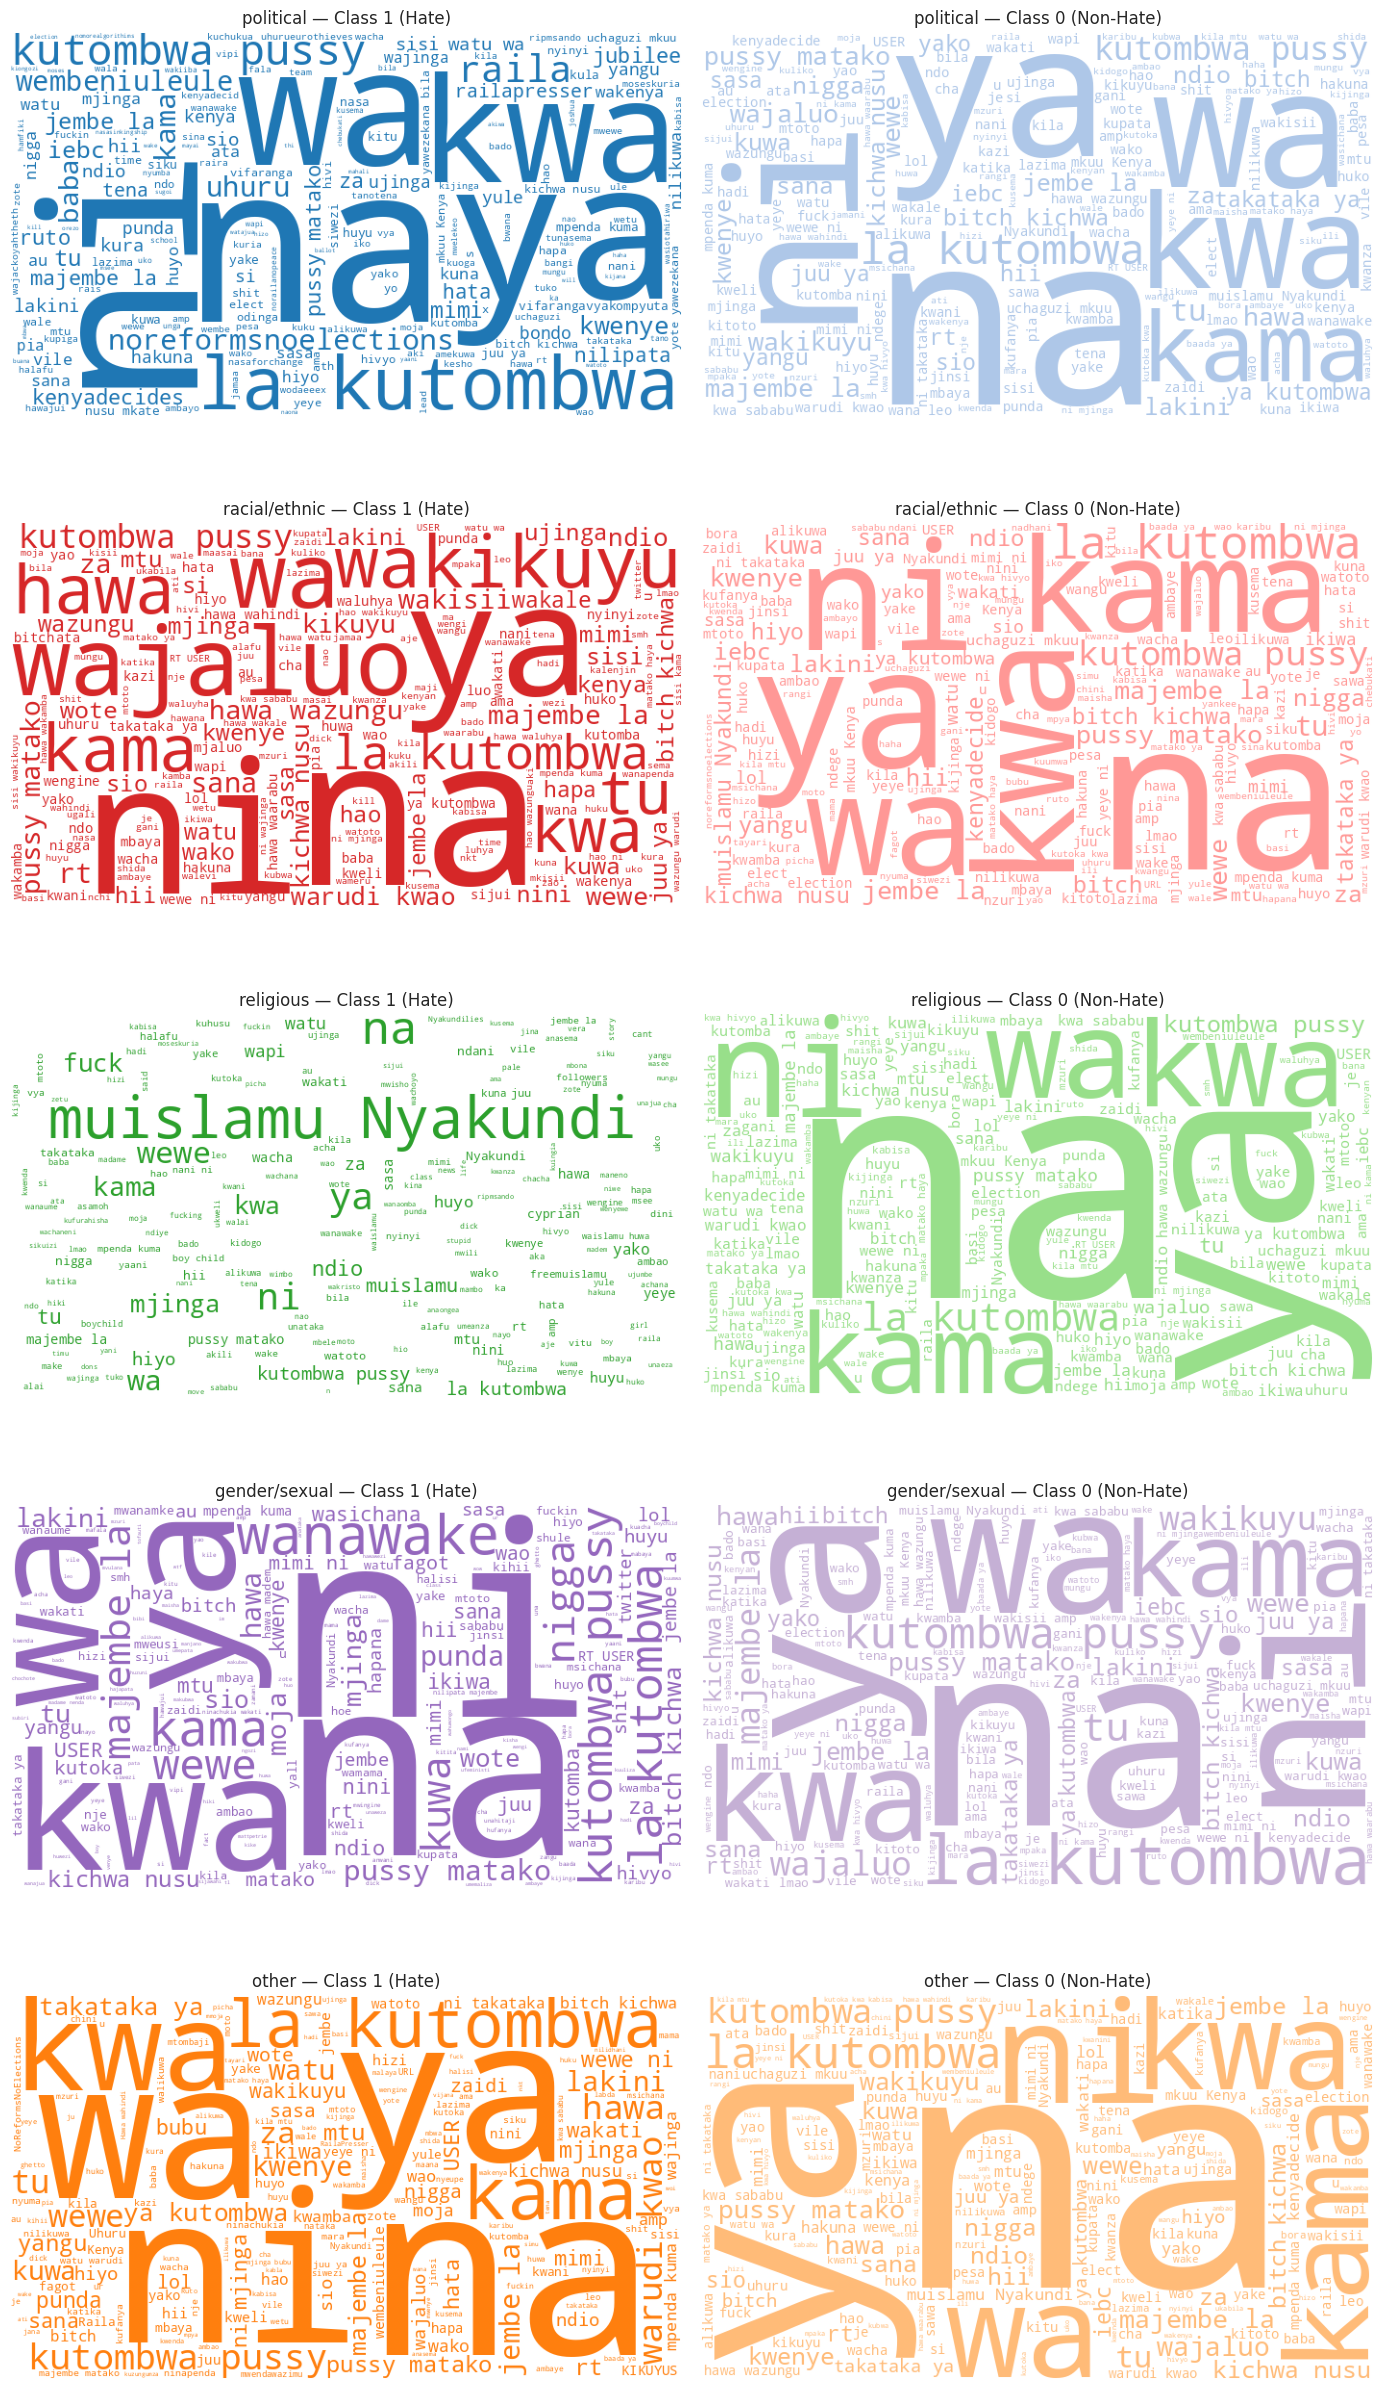

In [ ]:
# Colors per label
label_colors = {
    "political": ("#1f77b4", "#aec7e8"),        # dark blue, light blue
    "racial/ethnic": ("#d62728", "#ff9896"),    # dark red, light red
    "religious": ("#2ca02c", "#98df8a"),        # dark green, light green
    "gender/sexual": ("#9467bd", "#c5b0d5"),    # dark purple, light purple
    "other": ("#ff7f0e", "#ffbb78")             # dark orange, light orange
}

plt.figure(figsize=(14, 5 * len(LABEL_COLS)))

for i, label in enumerate(LABEL_COLS):

    # ---- Extract class texts ----
    text_class1 = " ".join(df[df[label] == 1]["text"].astype(str).tolist())
    text_class0 = " ".join(df[df[label] == 0]["text"].astype(str).tolist())

    # ---- Create 2 word clouds ----
    wc1 = WordCloud(width=700, height=400, background_color="white",
                    colormap=None).generate(text_class1)
    wc0 = WordCloud(width=700, height=400, background_color="white",
                    colormap=None).generate(text_class0)

    # ---- Plot side-by-side ----
    plt.subplot(len(LABEL_COLS), 2, 2*i+1)
    plt.imshow(wc1.recolor(color_func=lambda *args, **kwargs: label_colors[label][0]))
    plt.axis("off")
    plt.title(f"{label} — Class 1 (Hate)")

    plt.subplot(len(LABEL_COLS), 2, 2*i+2)
    plt.imshow(wc0.recolor(color_func=lambda *args, **kwargs: label_colors[label][1]))
    plt.axis("off")
    plt.title(f"{label} — Class 0 (Non-Hate)")

plt.tight_layout()
plt.show()


In [ ]:
import random
import numpy as np
import torch
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.metrics import f1_score
from tqdm import tqdm
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make cuDNN deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)   # <<< SET SEED HERE


Device: cuda


In [ ]:
#######################################################
# 1. LOAD SWAHILI TRAIN DATA
#######################################################

df = pd.read_csv("/content/gdrive/MyDrive/subtask_2swa/swa_train.csv")
print(df.head())
print("Dataset shape:", df.shape)

TEXT_COL = "text"
LABEL_COLS = ["political","racial/ethnic","religious","gender/sexual","other"]
NUM_LABELS = len(LABEL_COLS)

#######################################################
# 2. MULTILABEL STRATIFIED 80/20 SPLIT
#######################################################

X = df[TEXT_COL].values
Y = df[LABEL_COLS].values

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

for train_idx, val_idx in msss.split(X, Y):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)

print("Train:", train_df.shape, " Val:", val_df.shape)

#######################################################
# 3. DATASET CLASS
#######################################################

class SwahiliDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df[TEXT_COL].astype(str).tolist()
        self.labels = df[LABEL_COLS].values
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float)
        }


#######################################################
# 4. CHOOSE MODEL: AfroXLM-R OR XLM-R-base
#######################################################

MODEL_NAME = "castorini/afriberta_large"   # OPTION 1: AfroXLM-R (best for African langs)
# MODEL_NAME = "xlm-roberta-base"          # OPTION 2: XLM-R base

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def create_model():
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        problem_type="multi_label_classification"
    )
    return model.to(DEVICE)

criterion = torch.nn.BCEWithLogitsLoss()

#######################################################
# 5. TRAIN LOOP
#######################################################

def train_one(model, train_loader, val_loader, epochs=3):

    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(epochs):
        model.train()
        ep_loss = []
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            out = model(**batch)
            loss = criterion(out.logits, batch["labels"])
            loss.backward()
            optimizer.step()
            ep_loss.append(loss.item())
        print("Train Loss:", np.mean(ep_loss))

    # ---- validation ----
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            labels = batch["labels"].numpy()
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits = model(**batch).logits.sigmoid().cpu().numpy()

            preds.append(logits)
            trues.append(labels)

    preds = np.vstack(preds)
    trues = np.vstack(trues)

    bin_preds = (preds > 0.30).astype(int)  # threshold=0.3

    f1 = f1_score(trues, bin_preds, average="micro")
    print("VAL f1-micro:", f1)

    return model


#######################################################
# 6. BUILD DATA LOADERS
#######################################################

train_ds = SwahiliDataset(train_df, tokenizer)
val_ds   = SwahiliDataset(val_df, tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

#######################################################
# 7. TRAIN FINAL MODEL
#######################################################

model = create_model()
model = train_one(model, train_loader, val_loader, epochs=3)

#######################################################
# 8. SAVE TRAINED MODEL
#######################################################

model.save_pretrained("./swa_final_model")
tokenizer.save_pretrained("./swa_final_model")

print("Model saved to ./swa_final_model")


                                     id  \
0  swa_53de6a7a4d0123b5755da79d8d97a82f   
1  swa_ee2533cb334df97236ea2bcfda0d6823   
2  swa_1dd81b5985840a55b1ab292aa65d11a8   
3  swa_18589adc3945e20c5e5c61e10245fad1   
4  swa_aee76fc4cd1c6c6c09e19ba5ddd3901a   

                                                text  political  \
0  uwizi rt kenyan rao akishinda nitachinja kuku ...          0   
1  wakikuyu ndio wako na manyumba za kukodeshwa t...          0   
2  wakikuyu ni wezi power hungry and this time we...          0   
3  wakikuyu sijui shida yenu ni nini kuogopa rail...          0   
4                      wakikuyu walisogwa hwakuumbwa          0   

   racial/ethnic  religious  gender/sexual  other  
0              1          0              0      0  
1              1          0              0      0  
2              1          0              0      0  
3              1          0              0      0  
4              1          0              0      0  
Dataset shape: (6991, 7)
T

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 350/350 [01:44<00:00,  3.35it/s]


Train Loss: 0.21932591346757752


Epoch 2: 100%|██████████| 350/350 [01:43<00:00,  3.39it/s]


Train Loss: 0.15991719317223343


Epoch 3: 100%|██████████| 350/350 [01:42<00:00,  3.42it/s]


Train Loss: 0.12625857385673694
VAL f1-micro: 0.6859296482412061


/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


Model saved to ./swa_final_model


In [ ]:
dev = pd.read_csv("/content/gdrive/MyDrive/subtask_2swa/swa_dev.csv")


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)
texts = dev["text"].tolist()

preds = []
model.eval()
for t in texts:
    encoded = tokenizer(t, return_tensors="pt", truncation=True, padding=True).to(DEVICE)
    with torch.no_grad():
        logits = model(**encoded).logits
        pred = torch.sigmoid(logits).cpu().numpy()
    preds.append((pred > 0.5).astype(int)[0])


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Using device: cuda


In [ ]:
LABEL_COLS = ["political","racial/ethnic","religious","gender/sexual","other"]

pred_df = pd.DataFrame(preds, columns=LABEL_COLS)
submit_df = pd.concat([dev[["id"]], pred_df], axis=1)


In [ ]:
submit_df.to_csv("submission.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.metrics import f1_score
from tqdm import tqdm
import random
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

###########################################################
# 1. SET SEED (Reproducibility)
###########################################################
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

###########################################################
# 2. LOAD TRAIN DATA
###########################################################
df = pd.read_csv("/content/gdrive/MyDrive/subtask_2swa/swa_train.csv")

TEXT_COL = "text"
LABEL_COLS = ["political","racial/ethnic","religious","gender/sexual","other"]
NUM_LABELS = len(LABEL_COLS)

###########################################################
# 3. SPLIT 80/20
###########################################################
X = df[TEXT_COL].values
Y = df[LABEL_COLS].values

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

for train_idx, val_idx in msss.split(X, Y):
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)

###########################################################
# 4. DATASET CLASS
###########################################################
class SwahiliDataset(Dataset):
    def __init__(self, df, tokenizer, is_train=True):
        self.texts = df[TEXT_COL].astype(str).tolist()
        self.is_train = is_train
        if is_train:
            self.labels = df[LABEL_COLS].values
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        item = {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0)
        }

        if self.is_train:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)

        return item

###########################################################
# 5. TRAIN FUNCTION
###########################################################
criterion = torch.nn.BCEWithLogitsLoss()

def train_model(model_name, save_path, epochs=5):
    print(f"\n=== TRAINING {model_name} ===")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=NUM_LABELS,
        problem_type="multi_label_classification"
    ).to(DEVICE)

    train_ds = SwahiliDataset(train_df, tokenizer)
    val_ds   = SwahiliDataset(val_df, tokenizer)

    train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=16, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    for epoch in range(epochs):
        model.train()
        losses = []
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            out = model(**batch)
            loss = criterion(out.logits, batch["labels"])
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f"Epoch {epoch+1} Loss:", np.mean(losses))

    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            labels = batch["labels"].numpy()
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits = model(**batch).logits.sigmoid().cpu().numpy()

            preds.append(logits)
            trues.append(labels)

    preds = np.vstack(preds)
    trues = np.vstack(trues)
    bin_preds = (preds > 0.30).astype(int)

    f1 = f1_score(trues, bin_preds, average="micro")
    print("VAL F1:", f1)

    model.save_pretrained(save_path)
    tokenizer.save_pretrained(save_path)

    return save_path


###########################################################
# 6. TRAIN BOTH MODELS
###########################################################
path_A = train_model("castorini/afriberta_large", "./model_A")
path_B = train_model("Davlan/afro-xlmr-large", "./model_B")

###########################################################
# 7. PREDICT DEV WITH BOTH MODELS
###########################################################
def predict_model(model_path, dev_df):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(DEVICE)
    model.eval()

    dev_ds = SwahiliDataset(dev_df, tokenizer, is_train=False)
    dev_loader = DataLoader(dev_ds, batch_size=16, shuffle=False)

    all_preds = []

    with torch.no_grad():
        for batch in dev_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits = model(**batch).logits.sigmoid().cpu().numpy()
            all_preds.append(logits)

    return np.vstack(all_preds)

###########################################################
# 8. LOAD DEV FILE
###########################################################
dev_df = pd.read_csv("/content/gdrive/MyDrive/subtask_2swa/swa_dev.csv")

###########################################################
# 9. GET PREDICTIONS FROM BOTH MODELS
###########################################################
pred_A = predict_model("./model_A", dev_df)
pred_B = predict_model("./model_B", dev_df)

###########################################################
# 10. ENSEMBLE (average)
###########################################################
final_pred = (pred_A + pred_B) / 2
final_bin = (final_pred > 0.30).astype(int)

###########################################################
# 11. SAVE CSV (Correct 6-column format)
###########################################################
out = pd.DataFrame({
    "id": dev_df["id"],
    "political": final_bin[:,0],
    "racial/ethnic": final_bin[:,1],
    "religious": final_bin[:,2],
    "gender/sexual": final_bin[:,3],
    "other": final_bin[:,4],
})

out.to_csv("pred_swa.csv", index=False)
print("Saved pred_swa.csv!")


Device: cuda

=== TRAINING castorini/afriberta_large ===


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 350/350 [01:42<00:00,  3.40it/s]


Epoch 1 Loss: 0.2449644193478993


100%|██████████| 350/350 [01:43<00:00,  3.38it/s]


Epoch 2 Loss: 0.17398643151990004


100%|██████████| 350/350 [01:42<00:00,  3.42it/s]


Epoch 3 Loss: 0.14671791157552175


 23%|██▎       | 79/350 [00:23<01:19,  3.40it/s]